<a href="https://colab.research.google.com/github/pokablive/class-jyouhoushori/blob/main/vae_ipynb_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder

VAE, 変分オートエンコーダ

In [2]:
import os
import sys

from collections import OrderedDict
from copy import deepcopy
from time import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F

## データの準備

20newsgroupsを利用します．以下のようにbowを作成します．

In [3]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words="english")

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names_out()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 0.777s.
Extracting tf features for LDA...
done in 0.815s.


In [4]:
word2id = tf_vectorizer.vocabulary_
word2id

{'sure': 872,
 'story': 860,
 'did': 303,
 'statement': 854,
 'media': 589,
 'pro': 714,
 'israeli': 497,
 'world': 985,
 'having': 444,
 'letter': 535,
 'try': 914,
 'think': 897,
 'reason': 745,
 'report': 760,
 'clearly': 229,
 'reports': 762,
 'received': 748,
 'government': 424,
 'makes': 573,
 'away': 146,
 'look': 554,
 'jews': 502,
 'got': 422,
 'power': 703,
 'expect': 359,
 'people': 670,
 'read': 741,
 'faq': 369,
 'actually': 88,
 'accept': 83,
 'hard': 441,
 'atheism': 138,
 'need': 620,
 'little': 546,
 'faith': 366,
 'runs': 781,
 'jim': 503,
 'sorry': 837,
 'oh': 644,
 'just': 508,
 'end': 341,
 'maybe': 584,
 'start': 851,
 'new': 625,
 'newsgroup': 627,
 'alt': 103,
 'won': 978,
 'big': 162,
 'don': 321,
 'points': 691,
 'like': 540,
 'know': 516,
 'ask': 134,
 'question': 734,
 'sort': 838,
 'want': 954,
 'continue': 258,
 'israel': 496,
 'stop': 859,
 'asking': 136,
 'questions': 735,
 'work': 981,
 'bad': 149,
 'attack': 139,
 'group': 429,
 'center': 203,
 'policy

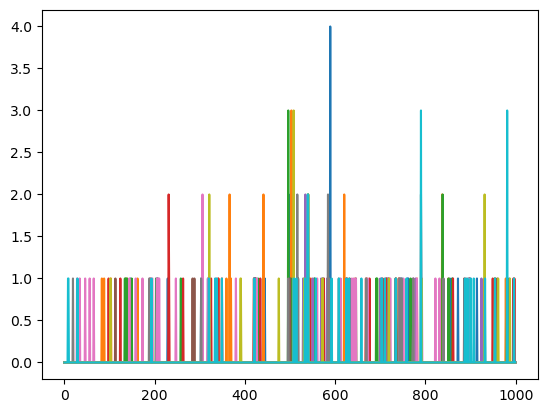

In [5]:
plt.plot(tf[:10, :].toarray().T);

In [6]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print("Number of docs for training = {}".format(docs_tr.shape[0]))
print("Number of docs for test = {}".format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print(f"Number of tokens in training set = {n_tokens}")
print(
    "Sparsity = {}".format(len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1]))
)

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480263
Sparsity = 0.0253936


In [7]:
docs_tr

<10000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 253936 stored elements in Compressed Sparse Row format>

In [8]:
docs_te

<1314x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 32295 stored elements in Compressed Sparse Row format>

In [9]:
class VariationlAutoEncoder(nn.Module):
    def __init__(self, in_features:int=2000, n_components:int=20):
        super().__init__()
        self.in_features = in_features
        self.n_components = n_components
        # build layers
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.n_components*2),
            # nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.n_components, self.in_features),
            nn.Softmax(dim=1),
        )

    def forward(self, x:torch.Tensor):
        encoded = self.encoder(x)
        mu = encoded[:,:self.n_components]
        log_var = encoded[:,self.n_components]
        z = self.rt(mu,log_var)
        
        return encoded, self.decoder(z),mu,log_var
    
    def rt(self, mu, logvar):
        if self.training:
            std = (logvar**0.5).exp()
            eps = torch.rand_like(mu)
            z = eps * std + mu
        else:
            z = mu
        return z

ae = VariationlAutoEncoder()
display(ae)

VariationlAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=2000, bias=True)
    (1): Softmax(dim=1)
  )
)

In [10]:
x = torch.from_numpy(docs_tr[:32].toarray().astype(np.float32))
latent_vector, p, *_  = ae(x)
latent_vector.shape, p.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1000 and 2000x40)

In [72]:
def cross_emtropy(pred_proba,bow):
    return - (torch.log(pred_proba)*bow).sum(1).mean()

cross_emtropy(p,x)

NameError: name 'p' is not defined

In [ ]:
def kld(mu,)

## VAEによる文書モデリング

VAEの気持ち：  
潜在ベクトルの各要素が標準正規分布に従って生成されていると仮定したAuto Encoder．

### 再パラメータ化トリック

### 損失関数

Cross Entropy + KL Divergence

Cross Entropyはほとんど再構成誤差，KL Divergenceは正則化項の役割を行っているとも取れる．

> 正則化は、学習時に用いる式に項を追加することによってとりうる重みの値の範囲を制限し、過度に重みが訓練データに対してのみ調整される（過学習する）ことを防ぐ役割を果たします。   
> [正則化とは – 【AI・機械学習用語集】](https://zero2one.jp/ai-word/regularization/#:~:text=%E6%AD%A3%E5%89%87%E5%8C%96%E3%81%AF%E3%80%81%E5%AD%A6%E7%BF%92%E6%99%82%E3%81%AB,%E9%98%B2%E3%81%90%E5%BD%B9%E5%89%B2%E3%82%92%E6%9E%9C%E3%81%9F%E3%81%97%E3%81%BE%E3%81%99%E3%80%82&text=%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AB%E3%81%8A%E3%81%84%E3%81%A6%E9%81%8E%E5%AD%A6%E7%BF%92,%E9%81%B8%E6%8A%9E%E8%82%A2%E3%82%92%EF%BC%91%E3%81%A4%E9%81%B8%E3%81%B9%E3%80%82)

### 類似単語検索

### 可視化

## Gaussian Softmax Trickを使ったVAE（GSM）による文書モデリング

GSMの気持ち：  
潜在ベクトルの仮定する事前分布は，「本当に標準正規分布でいいの？」→もっと良い確率分布がありそう→Dirichlet分布を使いたい→VAEでは使い辛い→ガウス分布を使って近似しよう！

### 類似単語検索

### 可視化